In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("../Data/BE_C0220150101_20230116.csv", parse_dates=True, index_col=0)
# df = df[5::24] take values every 24 hours
# df["Unnamed: 0"] = df.apply(lambda x: x["Unnamed: 0"][:-6], axis=1)
df.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)
df.index = pd.to_datetime(df.index, utc=True)
df

,Biomass,Lignite,Gas,Coal,Oil,Geothermal,Hydro_storage,Hydro,Hydro_res,Nuclear,Other,Other_renew,Solar,Waste,Wind_off,Wind_on,Total,Carbon Intensity
2014-12-31 23:00:00+00:00,15.64,0.0,1526.672,480.240,0.0,0.0,287.765,0.396,0.0,14.375,412.3,0.0,0.000,186.9,6.591,2.301,2933.180,374.847284
2015-01-01 00:00:00+00:00,15.87,0.0,1510.418,479.136,0.0,0.0,131.427,0.396,0.0,14.375,466.2,0.0,0.000,188.3,6.383,2.665,2815.170,365.274426
2015-01-01 01:00:00+00:00,15.87,0.0,1482.726,480.240,0.0,0.0,0.000,0.396,0.0,14.370,463.4,0.0,0.000,189.7,6.747,2.808,2656.257,352.055268
2015-01-01 02:00:00+00:00,15.64,0.0,1350.286,481.344,0.0,0.0,0.000,0.396,0.0,14.365,444.5,0.0,0.000,186.2,6.877,3.081,2502.689,341.757340
2015-01-01 03:00:00+00:00,15.41,0.0,1284.668,481.344,0.0,0.0,0.000,0.407,0.0,14.370,417.9,0.0,0.000,187.6,5.291,4.238,2411.228,337.423454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 09:00:00+00:00,27.83,0.0,248.024,0.000,0.0,0.0,0.000,0.066,0.0,24.505,0.0,0.0,26.425,72.8,26.338,27.859,453.847,43.355655
2023-01-15 10:00:00+00:00,27.37,0.0,245.014,0.000,0.0,0.0,235.366,0.077,0.0,24.505,0.0,0.0,38.045,74.2,26.533,28.496,699.606,62.835100
2023-01-15 11:00:00+00:00,27.60,0.0,244.412,0.000,0.0,0.0,0.000,0.077,0.0,24.545,0.0,0.0,37.835,74.9,25.792,29.042,464.203,42.791574
2023-01-15 12:00:00+00:00,28.06,0.0,254.646,0.000,0.0,0.0,0.000,0.077,0.0,24.505,0.0,0.0,29.680,73.5,26.533,29.809,466.810,43.464618


In [3]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i : i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

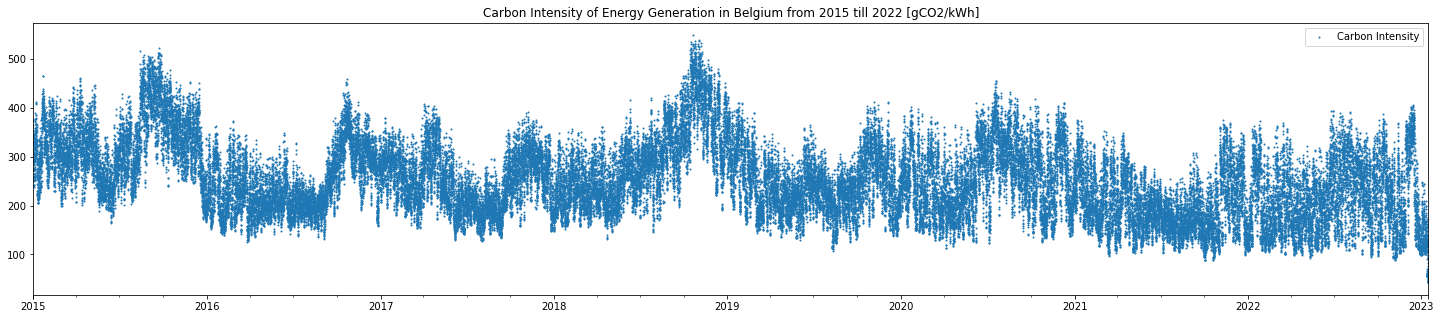

In [4]:
# Carbon Emission Intensity (CEI)
cei = df["Carbon Intensity"]
cei.plot(
    style=".",
    figsize=(25, 5),
    ms=2,
    title="Carbon Intensity of Energy Generation in Belgium from 2015 till 2022 [gCO2/kWh]",
    legend=["gCO2/kWh"],
)
plt.show()

In [5]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(cei, WINDOW_SIZE)
X1.shape, y1.shape

((70474, 5, 1), (70474,))

In [6]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5474, 5, 1), (5474,))

In [7]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, "relu"))
model1.add(Dense(1, "linear"))

model1.summary()

2023-01-17 23:22:27.904980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-17 23:22:27.905348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [8]:
cp1 = ModelCheckpoint("model1/", save_best_only=True)
model1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()],
)

In [9]:
model1.fit(
    X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1]
)

Epoch 1/10


2023-01-17 23:22:28.257729: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-17 23:22:28.837181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:22:28.928822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   7/1875 [..............................] - ETA: 16s - loss: 75497.3047 - root_mean_squared_error: 274.7677  

2023-01-17 23:22:29.047630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 14070.2520 - root_mean_squared_error: 118.6181

2023-01-17 23:22:43.891711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:22:43.935085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 20s 10ms/step - loss: 14070.2520 - root_mean_squared_error: 118.6181 - val_loss: 314.6969 - val_root_mean_squared_error: 17.7397
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 307.9767 - root_mean_squared_error: 17.5493 - val_loss: 353.9467 - val_root_mean_squared_error: 18.8135
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 250.1210 - root_mean_squared_error: 15.8152

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 19s 10ms/step - loss: 250.3101 - root_mean_squared_error: 15.8212 - val_loss: 297.4819 - val_root_mean_squared_error: 17.2477
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 242.4728 - root_mean_squared_error: 15.5715 - val_loss: 306.1777 - val_root_mean_squared_error: 17.4979
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 239.3592 - root_mean_squared_error: 15.4712 - val_loss: 301.7966 - val_root_mean_squared_error: 17.3723
Epoch 6/10
1870/1875 [============================>.] - ETA: 0s - loss: 239.6463 - root_mean_squared_error: 15.4805

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 21s 11ms/step - loss: 239.7896 - root_mean_squared_error: 15.4851 - val_loss: 294.6327 - val_root_mean_squared_error: 17.1649
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 237.3530 - root_mean_squared_error: 15.4063 - val_loss: 302.9729 - val_root_mean_squared_error: 17.4061
Epoch 8/10
1875/1875 [==============================] - 16s 9ms/step - loss: 237.8192 - root_mean_squared_error: 15.4214 - val_loss: 309.6609 - val_root_mean_squared_error: 17.5972
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 235.9559 - root_mean_squared_error: 15.3609 - val_loss: 295.5103 - val_root_mean_squared_error: 17.1904
Epoch 10/10
1875/1875 [==============================] - 15s 8ms/step - loss: 236.0151 - root_mean_squared_error: 15.3628 - val_loss: 309.0967 - val_root_mean_squared_error: 17.5811


In [10]:
from tensorflow.keras.models import load_model

model1 = load_model("model1/")

In [11]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(
    data={"Train Prediction": train_predictions, "Actuals": y_train1}
)
train_results

  34/1875 [..............................] - ETA: 5s

2023-01-17 23:25:21.965226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:25:21.997509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 8s 4ms/step


,Train Prediction,Actuals
0,334.642181,338.820792
1,339.002380,329.920773
2,324.658142,323.362881
3,319.438568,313.173764
4,308.292267,292.760369
...,...,...
59995,224.905869,212.461218
59996,204.332840,211.088725
59997,209.290909,224.440633
59998,232.862610,223.544287


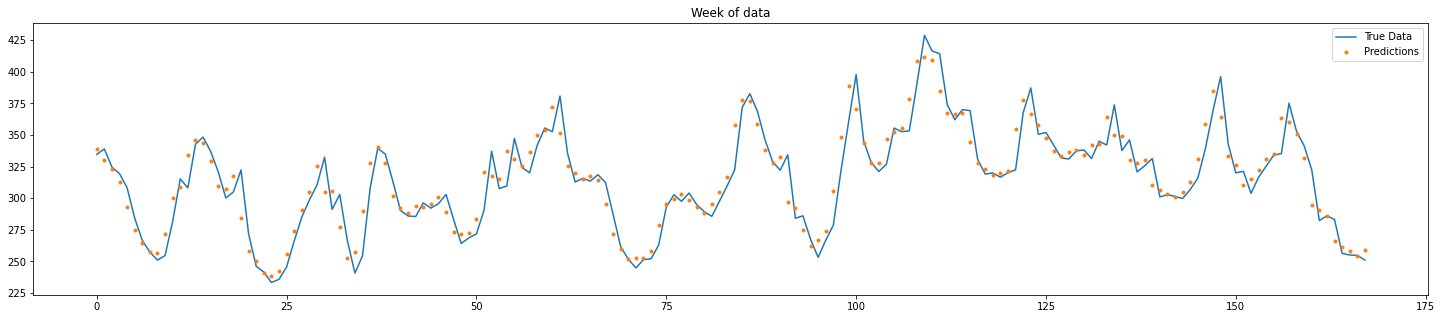

In [12]:
ax = train_results["Train Prediction"][: 7 * 24].plot(
    figsize=(25, 5),
    title="Week of data",
)
train_results["Actuals"][: 7 * 24].plot(style=".")
plt.legend(["True Data", "Predictions"])
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error as mse


def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={"Predictions": predictions, "Actuals": y})
    ax = df["Predictions"][:end].plot(
        figsize=(25, 5),
        title="Plot prediction vs actual data",
    )
    df["Actuals"][:end].plot(style=".")
    plt.legend(["True Data", "Predictions"])
    plt.show()
    return df, mse(y, predictions)

 35/172 [=====>........................] - ETA: 0s

2023-01-17 23:25:30.520584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:25:30.554145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - 1s 3ms/step


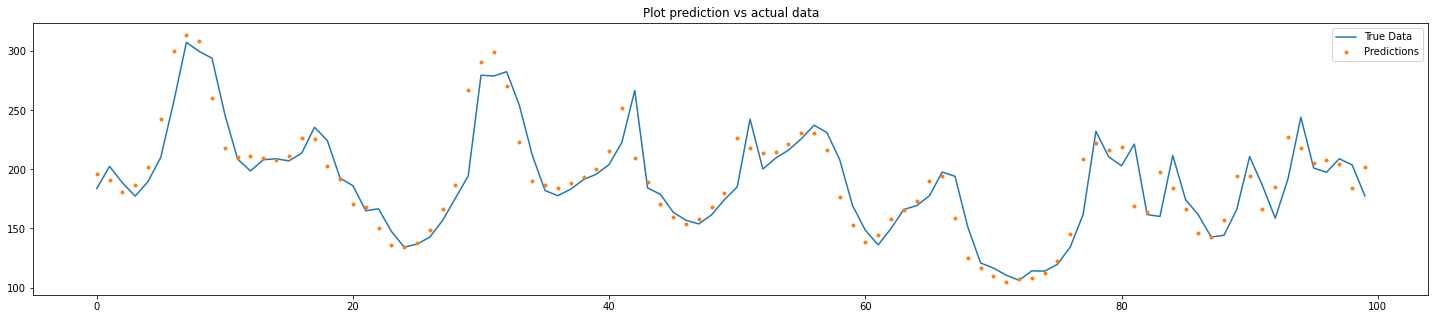

(      Predictions     Actuals
 0      183.716827  195.705410
 1      202.599594  191.454328
 2      188.727402  181.059453
 3      177.389587  186.816352
 4      189.648788  202.343294
 ...           ...         ...
 5469    56.872349   43.355655
 5470    48.086243   62.835100
 5471    90.042122   42.791574
 5472    40.413582   43.464618
 5473    50.380459   44.899481
 
 [5474 rows x 2 columns],
 324.93946769561927)

In [14]:
plot_predictions(model1, X_test1, y_test1)

In [15]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, "relu"))
model2.add(Dense(1, "linear"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [16]:
cp2 = ModelCheckpoint("model2/", save_best_only=True)
model2.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()],
)

In [17]:
model2.fit(
    X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2]
)

Epoch 1/10
  23/1875 [..............................] - ETA: 8s - loss: 9720.4648 - root_mean_squared_error: 98.5924   

2023-01-17 23:25:31.420407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 508.2060 - root_mean_squared_error: 22.5434

2023-01-17 23:25:40.961599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 11s 6ms/step - loss: 507.3824 - root_mean_squared_error: 22.5252 - val_loss: 330.8597 - val_root_mean_squared_error: 18.1895
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 246.6282 - root_mean_squared_error: 15.7044 - val_loss: 332.7494 - val_root_mean_squared_error: 18.2414
Epoch 3/10
1873/1875 [============================>.] - ETA: 0s - loss: 245.8280 - root_mean_squared_error: 15.6789

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 245.8203 - root_mean_squared_error: 15.6787 - val_loss: 322.3886 - val_root_mean_squared_error: 17.9552
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 244.1480 - root_mean_squared_error: 15.6252 - val_loss: 329.7080 - val_root_mean_squared_error: 18.1579
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 245.2600 - root_mean_squared_error: 15.6608

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 11s 6ms/step - loss: 245.2600 - root_mean_squared_error: 15.6608 - val_loss: 322.2105 - val_root_mean_squared_error: 17.9502
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 243.2833 - root_mean_squared_error: 15.5975 - val_loss: 322.6796 - val_root_mean_squared_error: 17.9633
Epoch 7/10
1872/1875 [============================>.] - ETA: 0s - loss: 244.1452 - root_mean_squared_error: 15.6251

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 244.1128 - root_mean_squared_error: 15.6241 - val_loss: 320.6239 - val_root_mean_squared_error: 17.9060
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 243.1214 - root_mean_squared_error: 15.5924 - val_loss: 348.2105 - val_root_mean_squared_error: 18.6604
Epoch 9/10
1866/1875 [============================>.] - ETA: 0s - loss: 243.2507 - root_mean_squared_error: 15.5965

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 243.4594 - root_mean_squared_error: 15.6032 - val_loss: 319.6269 - val_root_mean_squared_error: 17.8781
Epoch 10/10
1870/1875 [============================>.] - ETA: 0s - loss: 241.9112 - root_mean_squared_error: 15.5535

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 241.7212 - root_mean_squared_error: 15.5474 - val_loss: 315.1862 - val_root_mean_squared_error: 17.7535


 32/172 [====>.........................] - ETA: 0s

2023-01-17 23:27:10.256148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - 0s 2ms/step


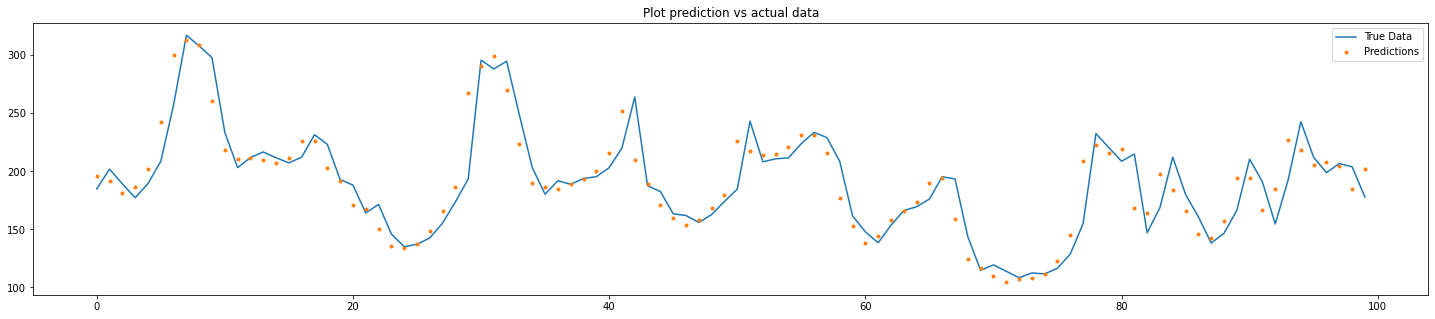

(      Predictions     Actuals
 0      184.864624  195.705410
 1      201.884125  191.454328
 2      189.219986  181.059453
 3      177.247635  186.816352
 4      189.454300  202.343294
 ...           ...         ...
 5469    53.813221   43.355655
 5470    45.601250   62.835100
 5471    76.001892   42.791574
 5472    37.348171   43.464618
 5473    50.588085   44.899481
 
 [5474 rows x 2 columns],
 322.79758340797855)

In [18]:
plot_predictions(model2, X_test1, y_test1)

In [19]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, "relu"))
model3.add(Dense(1, "linear"))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [20]:
cp3 = ModelCheckpoint("model3/", save_best_only=True)
model3.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()],
)

In [21]:
model3.fit(
    X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3]
)

Epoch 1/10


2023-01-17 23:27:11.349178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:27:11.434089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:27:11.526644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 17080.4336 - root_mean_squared_error: 130.6921

2023-01-17 23:27:27.192084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:27:27.229823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 20s 10ms/step - loss: 17036.7148 - root_mean_squared_error: 130.5248 - val_loss: 413.6238 - val_root_mean_squared_error: 20.3377
Epoch 2/10
1870/1875 [============================>.] - ETA: 0s - loss: 371.8125 - root_mean_squared_error: 19.2824

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 20s 11ms/step - loss: 371.4707 - root_mean_squared_error: 19.2736 - val_loss: 365.9226 - val_root_mean_squared_error: 19.1291
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 270.5018 - root_mean_squared_error: 16.4469

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 19s 10ms/step - loss: 270.5018 - root_mean_squared_error: 16.4469 - val_loss: 327.3271 - val_root_mean_squared_error: 18.0922
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 273.7108 - root_mean_squared_error: 16.5442 - val_loss: 357.4595 - val_root_mean_squared_error: 18.9066
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 260.9066 - root_mean_squared_error: 16.1526 - val_loss: 340.0522 - val_root_mean_squared_error: 18.4405
Epoch 6/10
1869/1875 [============================>.] - ETA: 0s - loss: 250.6246 - root_mean_squared_error: 15.8311

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 19s 10ms/step - loss: 250.5664 - root_mean_squared_error: 15.8293 - val_loss: 309.5778 - val_root_mean_squared_error: 17.5948
Epoch 7/10
1873/1875 [============================>.] - ETA: 0s - loss: 248.7033 - root_mean_squared_error: 15.7703

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 18s 9ms/step - loss: 248.6934 - root_mean_squared_error: 15.7700 - val_loss: 305.6917 - val_root_mean_squared_error: 17.4840
Epoch 8/10
1871/1875 [============================>.] - ETA: 0s - loss: 245.6403 - root_mean_squared_error: 15.6729

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1875/1875 [==============================] - 21s 11ms/step - loss: 245.8605 - root_mean_squared_error: 15.6799 - val_loss: 290.8033 - val_root_mean_squared_error: 17.0530
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 253.0654 - root_mean_squared_error: 15.9080 - val_loss: 304.3756 - val_root_mean_squared_error: 17.4464
Epoch 10/10
1875/1875 [==============================] - 15s 8ms/step - loss: 245.4036 - root_mean_squared_error: 15.6654 - val_loss: 330.0200 - val_root_mean_squared_error: 18.1665


 28/172 [===>..........................] - ETA: 0s

2023-01-17 23:30:16.188723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:30:16.221549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - 1s 3ms/step


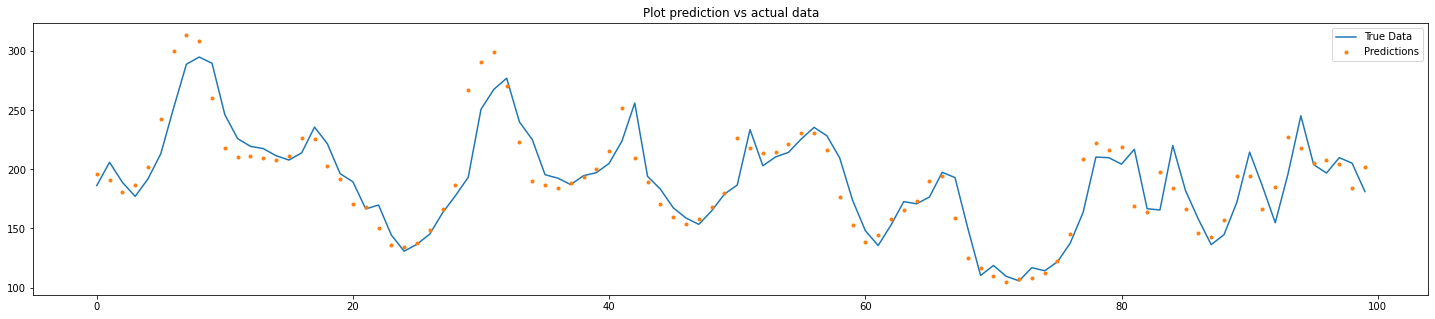

(      Predictions     Actuals
 0      186.311432  195.705410
 1      206.015884  191.454328
 2      189.121063  181.059453
 3      177.150436  186.816352
 4      192.004959  202.343294
 ...           ...         ...
 5469    48.630611   43.355655
 5470    37.245304   62.835100
 5471    84.483704   42.791574
 5472    22.604502   43.464618
 5473    43.018200   44.899481
 
 [5474 rows x 2 columns],
 383.22230098568565)

In [22]:
plot_predictions(model3, X_test1, y_test1)

In [23]:
cei_df = pd.DataFrame({"CEI": cei})

In [24]:
cei_df["Seconds"] = cei_df.index.map(pd.Timestamp.timestamp)

In [25]:
cei_df

,CEI,Seconds
2014-12-31 23:00:00+00:00,374.847284,1.420067e+09
2015-01-01 00:00:00+00:00,365.274426,1.420070e+09
2015-01-01 01:00:00+00:00,352.055268,1.420074e+09
2015-01-01 02:00:00+00:00,341.757340,1.420078e+09
2015-01-01 03:00:00+00:00,337.423454,1.420081e+09
...,...,...
2023-01-15 09:00:00+00:00,43.355655,1.673773e+09
2023-01-15 10:00:00+00:00,62.835100,1.673777e+09
2023-01-15 11:00:00+00:00,42.791574,1.673780e+09
2023-01-15 12:00:00+00:00,43.464618,1.673784e+09


In [26]:
day = 60 * 60 * 24
year = 365.2425 * day

cei_df["Day sin"] = np.sin(cei_df["Seconds"] * (2 * np.pi / day))
cei_df["Day cos"] = np.cos(cei_df["Seconds"] * (2 * np.pi / day))
cei_df["Year sin"] = np.sin(cei_df["Seconds"] * (2 * np.pi / year))
cei_df["Year cos"] = np.cos(cei_df["Seconds"] * (2 * np.pi / year))
cei_df

,CEI,Seconds,Day sin,Day cos,Year sin,Year cos
2014-12-31 23:00:00+00:00,374.847284,1.420067e+09,-2.588190e-01,0.965926,0.000788,1.000000
2015-01-01 00:00:00+00:00,365.274426,1.420070e+09,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 01:00:00+00:00,352.055268,1.420074e+09,2.588190e-01,0.965926,0.002222,0.999998
2015-01-01 02:00:00+00:00,341.757340,1.420078e+09,5.000000e-01,0.866025,0.002939,0.999996
2015-01-01 03:00:00+00:00,337.423454,1.420081e+09,7.071068e-01,0.707107,0.003656,0.999993
...,...,...,...,...,...,...
2023-01-15 09:00:00+00:00,43.355655,1.673773e+09,7.071068e-01,-0.707107,0.247237,0.968955
2023-01-15 10:00:00+00:00,62.835100,1.673777e+09,5.000000e-01,-0.866025,0.247931,0.968778
2023-01-15 11:00:00+00:00,42.791574,1.673780e+09,2.588190e-01,-0.965926,0.248625,0.968600
2023-01-15 12:00:00+00:00,43.464618,1.673784e+09,-1.045601e-13,-1.000000,0.249320,0.968421


In [27]:
cei_df = cei_df.drop("Seconds", axis=1)
cei_df

,CEI,Day sin,Day cos,Year sin,Year cos
2014-12-31 23:00:00+00:00,374.847284,-2.588190e-01,0.965926,0.000788,1.000000
2015-01-01 00:00:00+00:00,365.274426,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 01:00:00+00:00,352.055268,2.588190e-01,0.965926,0.002222,0.999998
2015-01-01 02:00:00+00:00,341.757340,5.000000e-01,0.866025,0.002939,0.999996
2015-01-01 03:00:00+00:00,337.423454,7.071068e-01,0.707107,0.003656,0.999993
...,...,...,...,...,...
2023-01-15 09:00:00+00:00,43.355655,7.071068e-01,-0.707107,0.247237,0.968955
2023-01-15 10:00:00+00:00,62.835100,5.000000e-01,-0.866025,0.247931,0.968778
2023-01-15 11:00:00+00:00,42.791574,2.588190e-01,-0.965926,0.248625,0.968600
2023-01-15 12:00:00+00:00,43.464618,-1.045601e-13,-1.000000,0.249320,0.968421


In [28]:
def df_to_X_y2(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i : i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [29]:
X2, y2 = df_to_X_y2(cei_df)
X2.shape, y2.shape

((70473, 6, 5), (70473,))

In [30]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5473, 6, 5), (5473,))

In [31]:
cei_training_mean = np.mean(X2_train[:, :, 0])
cei_trainig_std = np.std(X2_train[:, :, 0])


def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - cei_training_mean) / cei_trainig_std
    return X

In [32]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[-7.99244667e-01,  9.65925826e-01, -2.58819045e-01,
          5.07470580e-01, -8.61669084e-01],
        [-8.52258156e-01,  8.66025404e-01, -5.00000000e-01,
          5.06852820e-01, -8.62032609e-01],
        [-9.57011986e-01,  7.07106781e-01, -7.07106781e-01,
          5.06234800e-01, -8.62395691e-01],
        [-1.06283122e+00,  5.00000000e-01, -8.66025404e-01,
          5.05616520e-01, -8.62758329e-01],
        [-1.03281435e+00,  2.58819045e-01, -9.65925826e-01,
          5.04997980e-01, -8.63120524e-01],
        [-8.51974862e-01,  4.98392536e-12, -1.00000000e+00,
          5.04379181e-01, -8.63482276e-01]],

       [[-8.52258156e-01,  8.66025404e-01, -5.00000000e-01,
          5.06852820e-01, -8.62032609e-01],
        [-9.57011986e-01,  7.07106781e-01, -7.07106781e-01,
          5.06234800e-01, -8.62395691e-01],
        [-1.06283122e+00,  5.00000000e-01, -8.66025404e-01,
          5.05616520e-01, -8.62758329e-01],
        [-1.03281435e+00,  2.58819045e-01, -9.65925826e-01,
  

In [33]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, "relu"))
model4.add(Dense(1, "linear"))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [34]:
cp4 = ModelCheckpoint("model4/", save_best_only=True)
model4.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()],
)

In [35]:
model4.fit(
    X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4]
)

Epoch 1/10


2023-01-17 23:30:17.986176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:30:18.074649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:30:18.486447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1871/1875 [============================>.] - ETA: 0s - loss: 11834.8477 - root_mean_squared_error: 108.7881

2023-01-17 23:30:36.521215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:30:36.568606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 24s 12ms/step - loss: 11810.6094 - root_mean_squared_error: 108.6766 - val_loss: 438.9334 - val_root_mean_squared_error: 20.9507
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 284.7256 - root_mean_squared_error: 16.8738

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 20s 11ms/step - loss: 284.6725 - root_mean_squared_error: 16.8722 - val_loss: 253.6688 - val_root_mean_squared_error: 15.9270
Epoch 3/10
1873/1875 [============================>.] - ETA: 0s - loss: 187.8041 - root_mean_squared_error: 13.7042

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 22s 12ms/step - loss: 187.8298 - root_mean_squared_error: 13.7051 - val_loss: 236.3292 - val_root_mean_squared_error: 15.3730
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 177.7082 - root_mean_squared_error: 13.3307

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 22s 11ms/step - loss: 177.6294 - root_mean_squared_error: 13.3278 - val_loss: 229.7840 - val_root_mean_squared_error: 15.1586
Epoch 5/10
1871/1875 [============================>.] - ETA: 0s - loss: 173.3996 - root_mean_squared_error: 13.1681

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1875/1875 [==============================] - 24s 13ms/step - loss: 173.2935 - root_mean_squared_error: 13.1641 - val_loss: 223.6385 - val_root_mean_squared_error: 14.9545
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 170.4058 - root_mean_squared_error: 13.0540 - val_loss: 234.6777 - val_root_mean_squared_error: 15.3192
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 167.9675 - root_mean_squared_error: 12.9602 - val_loss: 235.0174 - val_root_mean_squared_error: 15.3303
Epoch 8/10
1875/1875 [==============================] - 19s 10ms/step - loss: 165.9586 - root_mean_squared_error: 12.8825 - val_loss: 233.8463 - val_root_mean_squared_error: 15.2920
Epoch 9/10
1875/1875 [==============================] - 19s 10ms/step - loss: 165.8885 - root_mean_squared_error: 12.8798 - val_loss: 241.1321 - val_root_mean_squared_error: 15.5284
Epoch 10/10
1875/1875 [==============================] - 20s 11ms/step - loss: 163.6929 - root_mean_s

 15/172 [=>............................] - ETA: 0s 

2023-01-17 23:33:44.770819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:33:44.804808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - 2s 8ms/step


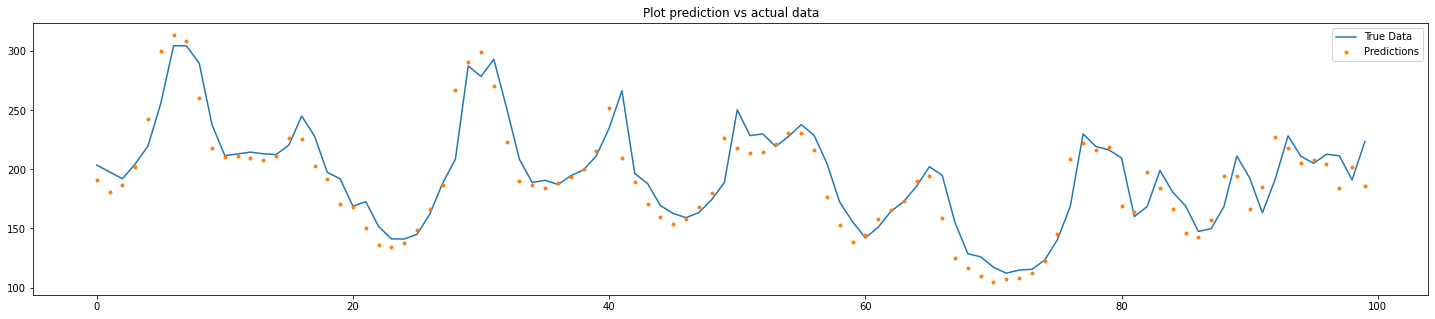

(      Predictions     Actuals
 0      203.653671  191.454328
 1      197.913956  181.059453
 2      192.061157  186.816352
 3      204.576126  202.343294
 4      219.801926  242.535895
 ...           ...         ...
 5468    70.094467   43.355655
 5469    66.919029   62.835100
 5470    77.739464   42.791574
 5471    68.072998   43.464618
 5472    70.297638   44.899481
 
 [5473 rows x 2 columns],
 279.9025120027928)

In [36]:
plot_predictions(model4, X2_test, y2_test)

In [75]:
solar_cei_df = pd.concat([df.Solar, cei_df], axis=1)

In [76]:
solar_cei_df

,Solar,CEI,Day sin,Day cos,Year sin,Year cos
2014-12-31 23:00:00+00:00,0.000,374.847284,-2.588190e-01,0.965926,0.000788,1.000000
2015-01-01 00:00:00+00:00,0.000,365.274426,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 01:00:00+00:00,0.000,352.055268,2.588190e-01,0.965926,0.002222,0.999998
2015-01-01 02:00:00+00:00,0.000,341.757340,5.000000e-01,0.866025,0.002939,0.999996
2015-01-01 03:00:00+00:00,0.000,337.423454,7.071068e-01,0.707107,0.003656,0.999993
...,...,...,...,...,...,...
2023-01-15 09:00:00+00:00,26.425,43.355655,7.071068e-01,-0.707107,0.247237,0.968955
2023-01-15 10:00:00+00:00,38.045,62.835100,5.000000e-01,-0.866025,0.247931,0.968778
2023-01-15 11:00:00+00:00,37.835,42.791574,2.588190e-01,-0.965926,0.248625,0.968600
2023-01-15 12:00:00+00:00,29.680,43.464618,-1.045601e-13,-1.000000,0.249320,0.968421


In [91]:
def df_to_X_y3(df, window_size=7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i : i + window_size]]
        X.append(row)
        label = [df_as_np[i + window_size][0], df_as_np[i + window_size][1]]
        y.append(label)
    return np.array(X), np.array(y)

In [92]:
X3, y3 = df_to_X_y3(solar_cei_df)
X3.shape, y3.shape

((70472, 7, 6), (70472, 2))

In [93]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5472, 7, 6), (5472, 2))

In [94]:
solar_training_mean3 = np.mean(X3_train[:, :, 0])
solar_training_std3 = np.std(X3_train[:, :, 0])

cei_training_mean3 = np.mean(X3_train[:, :, 1])
cei_training_std3 = np.std(X3_train[:, :, 1])


def preprocess3(X):
    X[:, :, 0] = (X[:, :, 0] - solar_training_mean3) / solar_training_std3
    X[:, :, 1] = (X[:, :, 1] - cei_training_mean3) / cei_training_std3


def preprocess_output3(y):
    y[:, 0] = (y[:, 0] - solar_training_mean3) / solar_training_std3
    y[:, 1] = (y[:, 1] - cei_training_mean3) / cei_training_std3
    return y

In [95]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [96]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[ 3.85381223, -1.04982296],
       [ 3.21511299, -0.97205124],
       [ 2.13797176, -0.76229301],
       ...,
       [ 1.01531752, -2.91772628],
       [ 0.66183315, -2.90863392],
       [ 0.07623242, -2.88924992]])

In [97]:
model5 = Sequential()
model5.add(InputLayer((7, 6)))
model5.add(LSTM(64))
model5.add(Dense(8, "relu"))
model5.add(Dense(2, "linear"))

model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                18176     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 2)                 18        
                                                                 
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


In [98]:
cp5 = ModelCheckpoint("model5/", save_best_only=True)
model5.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()],
)

In [99]:
model5.fit(
    X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5]
)

Epoch 1/10


2023-01-17 23:45:43.708296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:45:43.798091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:45:43.900793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1872/1875 [============================>.] - ETA: 0s - loss: 0.0485 - root_mean_squared_error: 0.2202

2023-01-17 23:46:02.891592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:46:02.948069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0484 - root_mean_squared_error: 0.2201 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1810
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.1444

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 23s 12ms/step - loss: 0.0208 - root_mean_squared_error: 0.1444 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1736
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1792
Epoch 4/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0196 - root_mean_squared_error: 0.1401

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 22s 12ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1693
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1693
Epoch 6/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.1381

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 21s 11ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 7/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0189 - root_mean_squared_error: 0.1375

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 8/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1369

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 22s 11ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635
Epoch 9/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.1365

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1875/1875 [==============================] - 22s 12ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1631
Epoch 10/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678


In [100]:
def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    s_preds, cei_preds = predictions[:, 0], predictions[:, 1]
    s_actuals, cei_actuals = y[:, 0], y[:, 1]
    df = pd.DataFrame(
        data={
            "CEI Predictions": cei_preds,
            "CEI Actuals": cei_actuals,
            "Solar Predictions": s_preds,
            "Solar Actuals": s_actuals,
        }
    )
    ax = df["CEI Predictions"][:end].plot(
        figsize=(25, 5),
        title="Plot prediction vs actual data",
    )
    df["CEI Actuals"][:end].plot(style=".")
    df["Solar Predictions"][:end].plot(style=".-")
    df["Solar Actuals"][:end].plot(style=".")
    plt.legend(["CEI Pred", "Cei ACT", "Solar Pred", "Solar ACT"])
    plt.show()
    return df[start:end]

 12/171 [=>............................] - ETA: 0s 

2023-01-17 23:51:08.421875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:51:08.468853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 1s 3ms/step


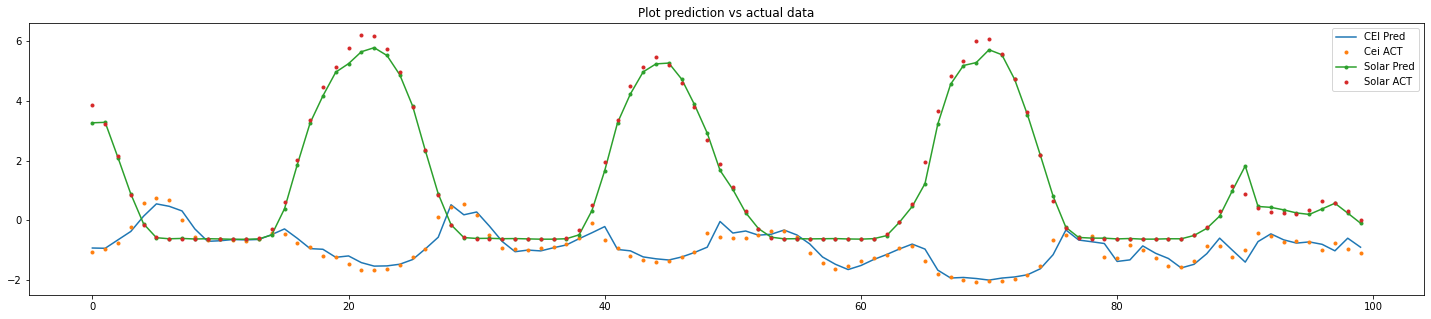

,CEI Predictions,CEI Actuals,Solar Predictions,Solar Actuals
0,-0.932453,-1.049823,3.265080,3.853812
1,-0.941485,-0.972051,3.280130,3.215113
2,-0.658815,-0.762293,2.098652,2.137972
3,-0.377462,-0.219319,0.881012,0.846919
4,0.134191,0.564201,-0.123486,-0.160435
...,...,...,...,...
95,-0.727681,-0.727819,0.194143,0.349310
96,-0.808701,-1.001600,0.378695,0.642111
97,-1.026651,-0.770142,0.568002,0.582944
98,-0.603613,-0.979053,0.237949,0.302280


In [101]:
plot_predictions2(model5, X3_test, y3_test)

In [102]:
def postprocess_cei(arr):
    arr = (arr * cei_training_std3) + cei_training_mean3
    return arr


def postprocess_solar(arr):
    arr = (arr * solar_training_std3) + solar_training_mean3
    return arr

In [103]:
def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    s_preds, cei_preds = postprocess_solar(predictions[:, 0]), postprocess_cei(predictions[:, 1])
    s_actuals, cei_actuals = postprocess_solar(y[:, 0]), postprocess_cei(y[:, 1])
    df = pd.DataFrame(
        data={
            "CEI Predictions": cei_preds,
            "CEI Actuals": cei_actuals,
            "Solar Predictions": s_preds,
            "Solar Actuals": s_actuals,
        }
    )
    ax = df["CEI Predictions"][:end].plot(
        figsize=(25, 5),
        title="Plot prediction vs actual data",
    )
    df["CEI Actuals"][:end].plot(style="-a")
    df["Solar Predictions"][:end].plot(style=".-")
    df["Solar Actuals"][:end].plot(style=".")
    plt.legend(["CEI Pred", "Cei ACT", "Solar Pred", "Solar ACT"])
    plt.show()
    return df[start:end]

171/171 [==============================] - 1s 3ms/step


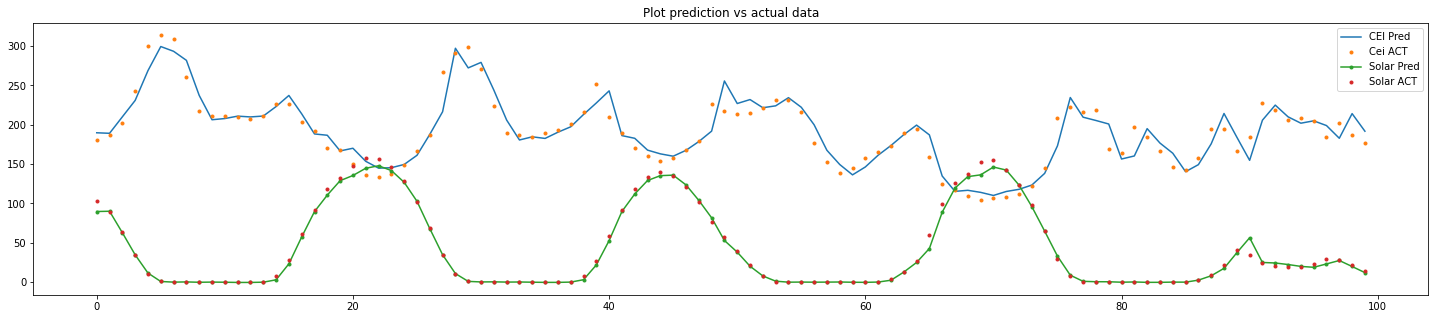

,CEI Predictions,CEI Actuals,Solar Predictions,Solar Actuals
0,189.747559,181.059453,89.737747,103.320
1,189.078964,186.816352,90.084961,88.585
2,210.003036,202.343294,62.827881,63.735
3,230.829636,242.535895,34.736530,33.950
4,268.703766,300.534378,11.562428,10.710
...,...,...,...,...
95,204.905411,204.895134,18.890224,22.470
96,198.908066,184.629067,23.147903,29.225
97,182.774689,201.762280,27.515293,27.860
98,214.089279,186.298054,19.900862,21.385


In [104]:
post_processed_df = plot_predictions2(model5, X3_test, y3_test)
post_processed_df

In [105]:
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 7, 32)             4992      
                                                                 
 lstm_9 (LSTM)               (None, 64)                24832     
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 2)                 18        
                                                                 
Total params: 30,362
Trainable params: 30,362
Non-trainable params: 0
_________________________________________________________________


In [107]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [108]:
model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6])

Epoch 1/10


2023-01-17 23:54:10.455668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:54:10.627691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:54:10.771769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:54:10.910895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   4/1875 [..............................] - ETA: 41s - loss: 0.8313 - root_mean_squared_error: 0.9117  

2023-01-17 23:54:11.070638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.2384

2023-01-17 23:54:39.361268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:54:39.435817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-17 23:54:39.494513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 39s 20ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 2/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0214 - root_mean_squared_error: 0.1462

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 35s 19ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1721
Epoch 3/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1794
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0200 - root_mean_squared_error: 0.1416 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0197 - root_mean_squared_error: 0.1404 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1722
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.1391

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 33s 18ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1713
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.1381

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 33s 18ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1699
Epoch 9/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.1378

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 36s 19ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1688
Epoch 10/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.1371

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1875/1875 [==============================] - 33s 18ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1634


In [109]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model7/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             832       
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_22 (Dense)            (None, 8)                 3080      
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
_________________________________________________________________


In [110]:
model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7])

Epoch 1/10


2023-01-17 23:59:28.665192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 0.1427 - root_mean_squared_error: 0.3777

2023-01-17 23:59:37.921396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.1424 - root_mean_squared_error: 0.3774 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3195
Epoch 2/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0391 - root_mean_squared_error: 0.1977

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 0.0391 - root_mean_squared_error: 0.1976 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2415
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0286 - root_mean_squared_error: 0.1690

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2141
Epoch 4/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.0249 - root_mean_squared_error: 0.1577

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 5/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.1522

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 6/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1486

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 10s 6ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1887
Epoch 7/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0215 - root_mean_squared_error: 0.1466

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1812
Epoch 8/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.1451

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 10s 5ms/step - loss: 0.0210 - root_mean_squared_error: 0.1451 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1800
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 10/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.1431

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


1875/1875 [==============================] - 10s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1430 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1786


2023-01-18 00:01:11.724824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-18 00:01:11.807066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-18 00:01:11.895060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 2s 7ms/step


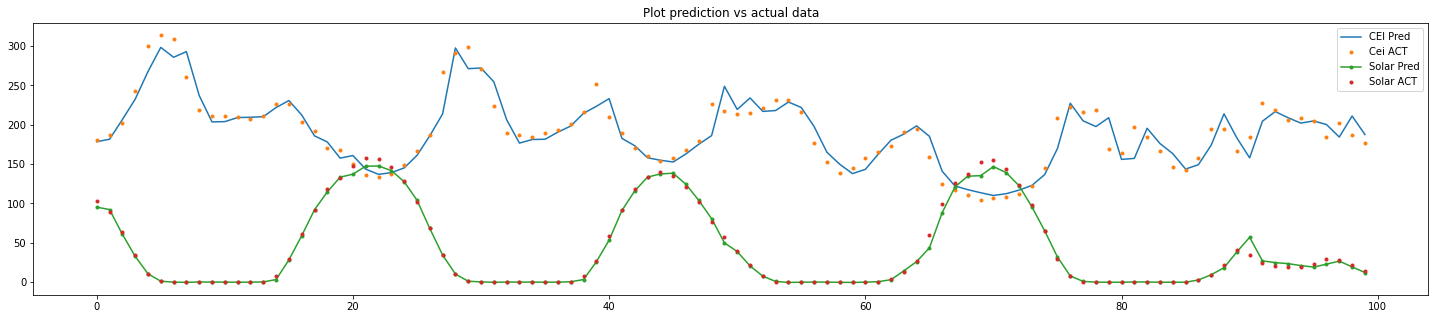

,CEI Predictions,CEI Actuals,Solar Predictions,Solar Actuals
0,178.322571,181.059453,95.220451,103.320
1,181.477097,186.816352,92.091049,88.585
2,206.448883,202.343294,60.759151,63.735
3,232.290710,242.535895,32.755924,33.950
4,267.477783,300.534378,10.481201,10.710
...,...,...,...,...
95,204.733337,204.895134,19.021660,22.470
96,200.160828,184.629067,22.722845,29.225
97,184.250748,201.762280,26.610748,27.860
98,210.995361,186.298054,19.252581,21.385


In [111]:
post_processed_df = plot_predictions2(model6, X3_test, y3_test)
post_processed_df

 93/171 [===============>..............] - ETA: 0s

2023-01-18 00:01:13.555935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 0s 2ms/step


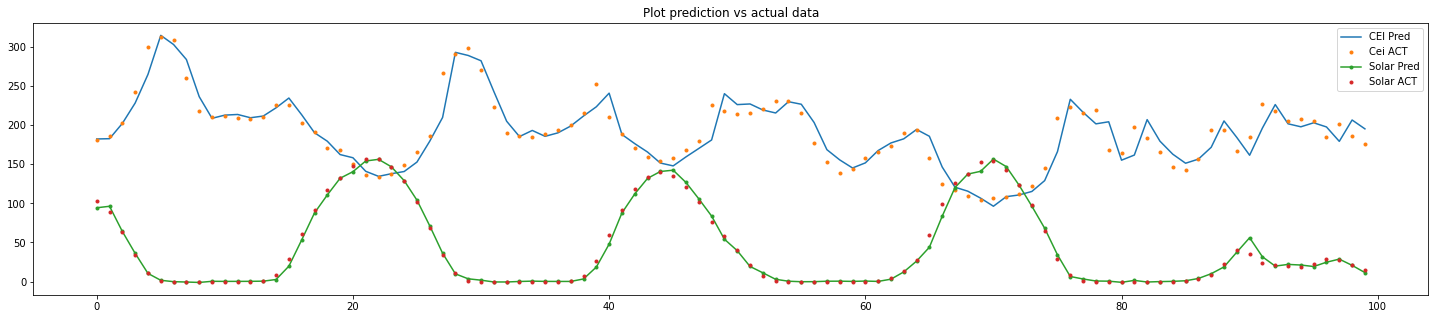

,CEI Predictions,CEI Actuals,Solar Predictions,Solar Actuals
0,182.395447,181.059453,94.387863,103.320
1,182.765732,186.816352,96.285294,88.585
2,202.324188,202.343294,64.059700,63.735
3,228.382492,242.535895,36.056145,33.950
4,265.015137,300.534378,10.381598,10.710
...,...,...,...,...
95,203.109985,204.895134,19.227236,22.470
96,197.775589,184.629067,24.735565,29.225
97,179.347290,201.762280,28.689180,27.860
98,206.663513,186.298054,20.712616,21.385


In [112]:
post_processed_df = plot_predictions2(model7, X3_test, y3_test)
post_processed_df